In [42]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [43]:
import pandas as pd
import datetime

In [44]:
target = '202103'

In [45]:
df = pd.read_table(f'data/parsed/{target}.tsv', index_col=0)
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
0,2021-03-01,05:15:00,NaN,NaN,NaN,NaN,NaN,0.0
1,2021-03-01,05:30:00,NaN,NaN,NaN,1.0,NaN,NaN
2,2021-03-01,05:55:00,6.0,NaN,NaN,NaN,NaN,NaN
3,2021-03-01,06:25:00,NaN,NaN,NaN,1.0,NaN,NaN
4,2021-03-01,08:00:00,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
772,2021-03-31,21:45:00,NaN,NaN,NaN,NaN,NaN,0.0
773,2021-03-31,21:50:00,NaN,NaN,NaN,NaN,NaN,1.0
774,2021-03-31,21:50:00,9.0,NaN,NaN,NaN,NaN,NaN
775,2021-03-31,21:50:00,NaN,NaN,NaN,1.0,NaN,NaN


datetime indexをセット

In [46]:
df['datetime'] = pd.to_datetime(df['date'] + 'T' + df['time'])
df = df.set_index('datetime')
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
datetime,,,,,,,,
2021-03-01 05:15:00,2021-03-01,05:15:00,NaN,NaN,NaN,NaN,NaN,0.0
2021-03-01 05:30:00,2021-03-01,05:30:00,NaN,NaN,NaN,1.0,NaN,NaN
2021-03-01 05:55:00,2021-03-01,05:55:00,6.0,NaN,NaN,NaN,NaN,NaN
2021-03-01 06:25:00,2021-03-01,06:25:00,NaN,NaN,NaN,1.0,NaN,NaN
2021-03-01 08:00:00,2021-03-01,08:00:00,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-03-31 21:45:00,2021-03-31,21:45:00,NaN,NaN,NaN,NaN,NaN,0.0
2021-03-31 21:50:00,2021-03-31,21:50:00,NaN,NaN,NaN,NaN,NaN,1.0
2021-03-31 21:50:00,2021-03-31,21:50:00,9.0,NaN,NaN,NaN,NaN,NaN


睡眠時間 (分) をsleep_minutes列にセット

In [47]:
import numpy as np

sleep_series = pd.Series()
sleep_in_time = 0
df['sleep_minutes'] = np.nan

for index, row in df.iterrows():
    if row['sleep'] == 1:
        sleep_in_time = index
    if row['sleep'] == 0 and sleep_in_time is not 0:
        delta = index - sleep_in_time
        df.loc[sleep_in_time, 'sleep_minutes'] = delta.total_seconds() / 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
wake_series = pd.Series()
wake_up_time = 0
df['wake_minutes'] = np.nan

for index, row in df.iterrows():
    if row['sleep'] == 0:
        wake_up_time = index
    if row['sleep'] == 1 and wake_up_time is not 0:
        delta = index - wake_up_time
        df.loc[wake_up_time, 'wake_minutes'] = delta.total_seconds() / 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


5分間隔のデータに整理

In [49]:
df_5min = df.groupby(pd.Grouper(freq='5min')).sum()
df_5min['sleep_minutes'] = df['sleep_minutes'].groupby(pd.Grouper(freq='5min')).mean()  # 同じ値が同じ時刻のデータすべてに入ってしまっている
df_5min['wake_minutes'] = df['wake_minutes'].groupby(pd.Grouper(freq='5min')).mean()  # 同じ値が同じ時刻のデータすべてに入ってしまっている

1時間ごとに、その時間に入眠した場合にどれくらい(分)眠り続けたかの平均

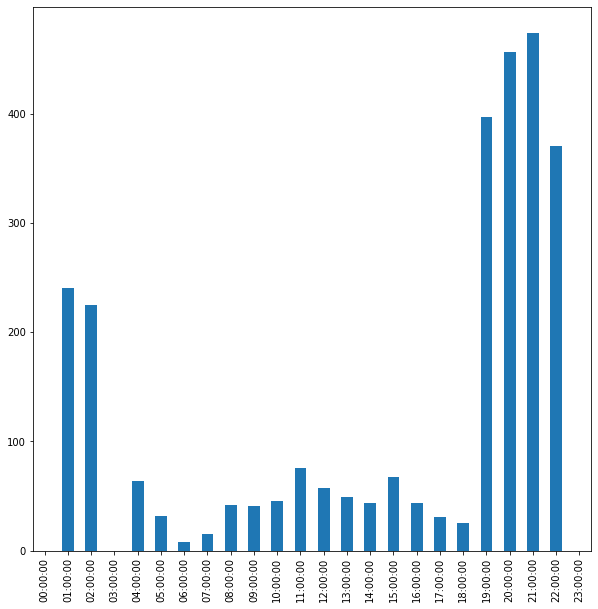

In [50]:
by_hour = df_5min.groupby(lambda x: datetime.time(hour=x.hour)).mean()
by_hour['sleep_minutes'].plot.bar(figsize=(10,10))

分布を確認

In [51]:
df_5min[df_5min['mothermilk'] > 0]['mothermilk'].describe()

count    89.000000
mean     10.202247
std       5.842983
min       3.000000
25%       6.000000
50%       7.000000
75%      14.000000
max      27.000000
Name: mothermilk, dtype: float64

In [52]:
df_5min[df_5min['milk'] > 0]['milk'].describe()

count    105.000000
mean     128.857143
std       50.025268
min       80.000000
25%       80.000000
50%      120.000000
75%      200.000000
max      200.000000
Name: milk, dtype: float64

In [53]:
df_5min[df_5min['expressedmilk'] > 0]['expressedmilk'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: expressedmilk, dtype: float64

In [54]:
df_5min[df_5min['sleep_minutes'] > 0]['sleep_minutes'].describe()

count    164.000000
mean     139.530488
std      189.795060
min        2.000000
25%       35.000000
50%       50.000000
75%       96.250000
max      633.000000
Name: sleep_minutes, dtype: float64

In [55]:
df_5min[df_5min['wake_minutes'] > 0]['wake_minutes'].describe()

count    165.000000
mean     129.163636
std       69.714513
min        2.000000
25%      100.000000
50%      145.000000
75%      175.000000
max      250.000000
Name: wake_minutes, dtype: float64

ある時刻より前の最後のイベントを取得する関数

In [56]:
def last_event_by(df, time, column):
    rows = df[:time][df[:time][column] > 0]
    if len(rows) == 0:
        return 0, 0, 0
    row = rows.iloc[-1]
    delta = time - row.name
    return row.name, row[column], delta.total_seconds() / 60

last_event_by(df_5min, pd.to_datetime('2020-10-02 03:00'), 'mothermilk')

(0, 0, 0)

睡眠時間と、その直前の各種イベントの内容をデータセット化

In [57]:
sleep_df = pd.DataFrame(columns=['datetime', 'hour', 'sleep_minutes', 'last_mothermilk', 'last_mothermilk_before', 'last_milk', 'last_milk_before', 'last_small_before', 'last_big_before', 'last_wake_minutes'])

for index, row in df_5min.iterrows():
    if row['sleep_minutes'] > 0:
        mothermilk_time, mothermilk, mothermilk_before = last_event_by(df_5min, index, 'mothermilk')
        milk_time, milk, milk_before = last_event_by(df_5min, index, 'milk')
        small_time, small, small_before = last_event_by(df_5min, index, 'small')
        big_time, big, big_before = last_event_by(df_5min, index, 'big')
        wake_time, wake, wake_before = last_event_by(df_5min, index, 'wake_minutes')
        sleep_df = sleep_df.append({
            'datetime': index,
            'hour': index.hour,
            'sleep_minutes': row['sleep_minutes'],
            'last_mothermilk': mothermilk,
            'last_mothermilk_before': mothermilk_before,
            'last_milk': milk,
            'last_milk_before': milk_before,
            'last_small_before': small_before,
            'last_big_before': big_before,
            'last_wake_minutes': wake
        }, ignore_index=True)

sleep_df

,datetime,hour,sleep_minutes,last_mothermilk,last_mothermilk_before,last_milk,last_milk_before,last_small_before,last_big_before,last_wake_minutes
0,2021-03-01 08:20:00,8,50.0,6.0,145.0,0,0,20.0,0,185.0
1,2021-03-01 11:30:00,11,35.0,3.0,85.0,0,0,210.0,0,140.0
2,2021-03-01 12:15:00,12,103.0,3.0,130.0,0,0,255.0,0,10.0
3,2021-03-01 16:00:00,16,50.0,6.0,105.0,0,0,35.0,0,122.0
4,2021-03-01 19:30:00,19,110.0,9.0,90.0,200,10,25.0,0,160.0
...,...,...,...,...,...,...,...,...,...,...
159,2021-03-31 04:10:00,4,105.0,10.0,490.0,200,500,490.0,490,10.0
160,2021-03-31 08:45:00,8,30.0,9.0,150.0,80,65,10.0,765,170.0
161,2021-03-31 12:05:00,12,78.0,9.0,350.0,80,60,210.0,965,172.0
162,2021-03-31 17:20:00,17,25.0,9.0,665.0,120,140,525.0,1280,235.0


In [58]:
sleep_df.to_csv(f'data/preprocessed/sleep_{target}.tsv', sep='\t')

In [59]:
sleep_daytime_df = sleep_df[sleep_df['hour'].apply(lambda hour: hour >= 6 and hour <= 18)]
sleep_daytime_df

,datetime,hour,sleep_minutes,last_mothermilk,last_mothermilk_before,last_milk,last_milk_before,last_small_before,last_big_before,last_wake_minutes
0,2021-03-01 08:20:00,8,50.0,6.0,145.0,0,0,20.0,0,185.0
1,2021-03-01 11:30:00,11,35.0,3.0,85.0,0,0,210.0,0,140.0
2,2021-03-01 12:15:00,12,103.0,3.0,130.0,0,0,255.0,0,10.0
3,2021-03-01 16:00:00,16,50.0,6.0,105.0,0,0,35.0,0,122.0
7,2021-03-02 08:05:00,8,40.0,7.0,130.0,200,765,135.0,640,145.0
...,...,...,...,...,...,...,...,...,...,...
156,2021-03-30 13:15:00,13,59.0,10.0,410.0,80,110,100.0,415,125.0
157,2021-03-30 17:20:00,17,26.0,10.0,655.0,120,145,150.0,660,190.0
160,2021-03-31 08:45:00,8,30.0,9.0,150.0,80,65,10.0,765,170.0
161,2021-03-31 12:05:00,12,78.0,9.0,350.0,80,60,210.0,965,172.0


In [60]:
sleep_daytime_df.to_csv(f'data/preprocessed/sleep_daytime_{target}.tsv', sep='\t')

In [61]:
sleep_df['hour'].apply(lambda hour: hour >= 6 and hour <= 18)

0       True
1       True
2       True
3       True
4      False
       ...  
159    False
160     True
161     True
162     True
163    False
Name: hour, Length: 164, dtype: bool